In [1]:
import numpy as np
import random
import pandas as pd
from matplotlib import pylab as plt
import matplotlib.gridspec as gridspec

import sys
# %matplotlib inline
sys.path += ['../scripts/']

import labornet as lbn
# paths
path_data = "data/"
path_local = "../"
path_exp_sim = "../results/csv/"
path_exp_fig = "../results/fig/"

# variable that says if results are saved in csv or fig
save_csv =  False
save_fig = False
run_random = False
run_random_ret = True
# setting seed for reproducibility
np.random.seed(12345)
random.seed(12345)
# paths
path_data = "../data/data_old_model/"
path_local = "../"
path_exp_sim = "../results/csv/"

# simulation conditions
shock = "FO_automation"#"beveridgeCurve"
# shock = "SMLautomation"
network_and_employment = "new_emp"
network_and_employment = "new_emp_selfloops"
file_occmobnet = "occupational_mobility_network.csv"



ipums_lab_file = "ipums_variables.csv"
ipums_mSML = "ipums_labs_mSML_manual.csv"
df_labs = pd.read_csv(path_data + ipums_lab_file)
df_labs = pd.read_csv(path_data + ipums_lab_file)
wage = np.array(df_labs["log_median_earnings"])
p = np.array(df_labs["auto_prob_average"])
df_sml = pd.read_csv(path_data + ipums_mSML)


ipums_employment2016 = "ipums_employment_2016.csv"
df_labs_emp = pd.read_csv(path_data+ipums_employment2016)
employment = np.array(df_labs_emp["IPUMS_CPS_av_monthly_employment_whole_period"])

# employment = np.array(df_labs_emp["IPUMS_CPS_av_monthly_employment_2016"])
if shock == "FO_automation":
    p = np.array(df_labs["auto_prob_average"])
elif shock == "SMLautomation":
    p = np.array(df_sml['mSML'])/5

δ_u = 0.016 + 0.00000001 # adding zeros since useful for defining names
δ_v = 0.012 + 0.00000001
γ_u = 10*δ_u
γ_v = γ_u
parameters = [δ_u, δ_v, γ_u, γ_v]
τ = 3 # the one is due to python starting to count until 0
r = 0.5502916755953751
# fraction of labor force with which to run solution (to align with simulation)
diminishing_factor = 1.0#0.01#1.0

# occupational mobility network
A_omn = np.genfromtxt(path_data + file_occmobnet, delimiter=',')
n = A_omn.shape[0]
# complete network
A_kn = np.ones([n,n])/n

# shock and time conditions
t_shock = 1000 # time at which shock starts
t_simulation = 10
shock_duration_years = 30
shock_duration = shock_duration_years * 52/6.75 # NOTE one time step ~6.75 weeks
time_array = [t*6.75/52 for t in range(t_simulation)]
t_steady_start = 25
t_steady_end = 75
# for sharp shocks
# t_transition_start = int(t_shock + 0.25*shock_duration)
# t_transition_end = int(t_shock + 0.75*shock_duration)
t_transition_start = int(t_shock +0*shock_duration)
t_transition_end = int(t_shock + 1*shock_duration)

# get demand in sigmoid
sigmoid_half_life, k = lbn.calibrate_sigmoid(shock_duration)

employment_0 = employment[:]
unemployment_0 = δ_u * employment_0
vacancies_0 = δ_v * employment_0
variables_0 = [employment_0, unemployment_0, vacancies_0]
# labor force is all workers, employed + unemployed
L = np.sum(employment_0 + unemployment_0)

# initial demand and target demand
D_0 = employment_0 + unemployment_0
# set random automation probabilities
D_f = lbn.labor_restructure(D_0, p)


parameter_names = "_deltau" + str(δ_u)[3:6] + "v" + str(δ_v)[3:6] + \
    "gamma" + str(γ_u)[2:5] + "_tau" + str(round(τ)) + "_shockduration" + \
    str(shock_duration_years) + "_dimfact" + str(diminishing_factor)[2:]




In [2]:
Variables_omn, U_all_omn, D_omn = lbn.run_numerical_solution(\
    lbn.fire_and_hire_workers, t_simulation, parameters,\
    variables_0, \
    lbn.target_demand_automation, D_0, D_f, t_shock, k, sigmoid_half_life, \
    lbn.matching_probability, A_omn, τ)

time  1
e5, u5, v5  142534.601529 2280.5550498100156 1710.4166436940154
spon sep  2280.5550498100156
state sep  0.0
Q[3,5] 0.00011719997666462694
sij 3,5 1.8192708631939634
sj 5 448.75777826044794
job offers  0.8795743264249989
F[3,5],  1.6001839440784567
got employed Fij_u.sum(axis=0)[5] 1048.8195575280859
sep workers[5] 2280.5550498100156
u[5] 2280.5550498100156
time  2
e5, u5, v5  140648.7622997314 3512.290542091945 3116.245001502887
spon sep  2250.3816032833256
state sep  0.0
Q[3,5] 0.00016658299424140535
sij 3,5 3.8731840127876564
sj 5 978.6146143513458
job offers  0.8582048192457367
F[3,5],  3.323985185599908
got employed Fij_u.sum(axis=0)[5] 1594.2153302426152
sep workers[5] 2250.3816032833256
u[5] 3512.290542091945
time  3
e5, u5, v5  139238.2324746687 4168.456815132656 4130.187477240333
spon sep  2227.813111977024
state sep  0.0
Q[3,5] 0.00021140540161885757
sij 3,5 5.881063136761111
sj 5 1431.313014025017
job offers  0.8451209154470565
F[3,5],  4.970209461941487
got employed 

In [3]:
emp = Variables_omn[0].sum(axis=1)
unemp = Variables_omn[1].sum(axis=1)

In [4]:
L = emp[0] + unemp [0]

In [5]:
print(A_omn[3, 5])
print(employment_0[5])

0.0009081944253866506
142534.601529


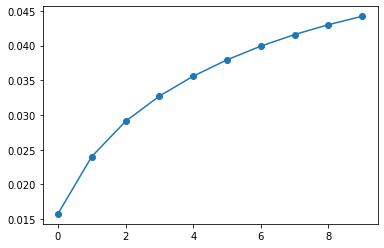

In [6]:
plt.plot(unemp/L, "o-")
plt.show()

In [ ]:

def lt_unemployment(U_all, τ):
    """ takes the array of all unemployment spells and with tau gives
    array with number of long term unemployed as defined by τ threshold
    """
    U_lt = u_longterm_from_jobspell(U_all, τ)
    # the -1 in tau is due to python counting starting on 0
    lt_unemployment = np.sum(U_all[:, τ:, :], axis=1)
    return lt_unemployment

# TODO check tau numbering and change in labornet in case needed
def u_longterm_from_jobspell(U_ltm, τ):
    # NOTE -1 since python starts counting on 1
    return np.sum(U_ltm[:, τ:, :], axis=1)

def save_result(Variables, U_all, D, τ, matrix, params=parameter_names, shock=shock):
    """Function that saves unemployment, vacnacies, employment, longterm unep,
    and demand into csv files
    """
    E, U, V = Variables
    names = ["u_per_occ_num","v_per_occ_num", "e_per_occ_num", \
            "ddagger_per_occ_num", "ltu_per_occ_num"]
    U_longterm = lt_unemployment(U_all, τ)
    for i, array in enumerate([U, V, E, D, U_longterm]):
        df = pd.DataFrame()
        df["id"] = np.arange(0, 464)
        df["label"] = df_labs["label"]
        for t in range(t_simulation):
            df["t" + str(t)] = array[t, :]
        df.to_csv(path_exp_sim + names[i] + matrix + shock + params+ ".csv" )
    print("saving file " + path_exp_sim + names[0] + matrix + shock + params + ".csv")

def save_percentage_change(Variables, U_all, τ, t_steady_start, t_steady_end, \
    t_transition_start, t_transition_end, matrix, params=parameter_names, \
        shock=shock):
    """Function that computes percentage change in unemployment and longterm
    unemployment. For steady state averages u and ltu from steady start to
    steady end
    """
    E, U, V = Variables
    U_lt = u_longterm_from_jobspell(U_all, τ)
    u_perc_change_num = lbn.percentage_change_u(E, U, t_steady_start, \
                t_steady_end, t_transition_start, t_transition_end)
    ltu_perc_change_num = lbn.percentage_change_ltu(E, U, U_lt, \
                t_steady_start, t_steady_end, t_transition_start, t_transition_end)
    df = pd.DataFrame()
    df["id"] = np.arange(0, 464)
    df["label"] = df_labs["label"]
    df["u_perc_change"] = u_perc_change_num
    df["ltu_perc_change"] = ltu_perc_change_num
    df.to_csv(path_exp_sim + "u_ltu_perc_change" + matrix + shock + params+ ".csv" )
    print("saving file "+ path_exp_sim + "u_ltu_perc_change" + matrix + shock + params+ ".csv")


# run and save model for kn
Variables_kn, U_all_kn, D_kn = lbn.run_numerical_solution(\
    lbn.fire_and_hire_workers, t_simulation, parameters,\
    variables_0, \
    lbn.target_demand_automation, D_0, D_f, t_shock, k, sigmoid_half_life, \
    lbn.matching_probability, A_kn, τ)

save_result(Variables_kn, U_all_kn, D_kn, τ, "kn")
save_percentage_change(Variables_kn, U_all_kn, τ, t_steady_start, t_steady_end, \
    t_transition_start, t_transition_end, "kn")


# run and save model for OMN
Variables_omn, U_all_omn, D_omn = lbn.run_numerical_solution(\
    lbn.fire_and_hire_workers, t_simulation, parameters,\
    variables_0, \
    lbn.target_demand_automation, D_0, D_f, t_shock, k, sigmoid_half_life, \
    lbn.matching_probability, A_omn, τ)

save_result(Variables_omn, U_all_omn, D_omn, τ, "OMN")
save_percentage_change(Variables_omn, U_all_omn, τ, t_steady_start, t_steady_end, \
    t_transition_start, t_transition_end, "OMN")